Scott Karr  
IS620 Project1

### Project requirements:

* Identify and load a network dataset that has some categorical information available for each node.
*   For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
*   Compare your centrality measures across your categorical groups.
*   You might use a t-test or another statistical measure to support your findings.

### References
https://patch.com/new-york/new-york-city/just-45-middle-schools-gave-specialized-high-schools-60-percent-their
https://www.nytimes.com/interactive/2018/06/29/nyregion/nyc-high-schools-middle-schools-shsat-students.html    
http://jonathansoma.com/lede/algorithms-2017/classes/networks/networkx-graphs-from-source-target-dataframe/  
https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

* Chi-squared was used instead of a t-test to ev

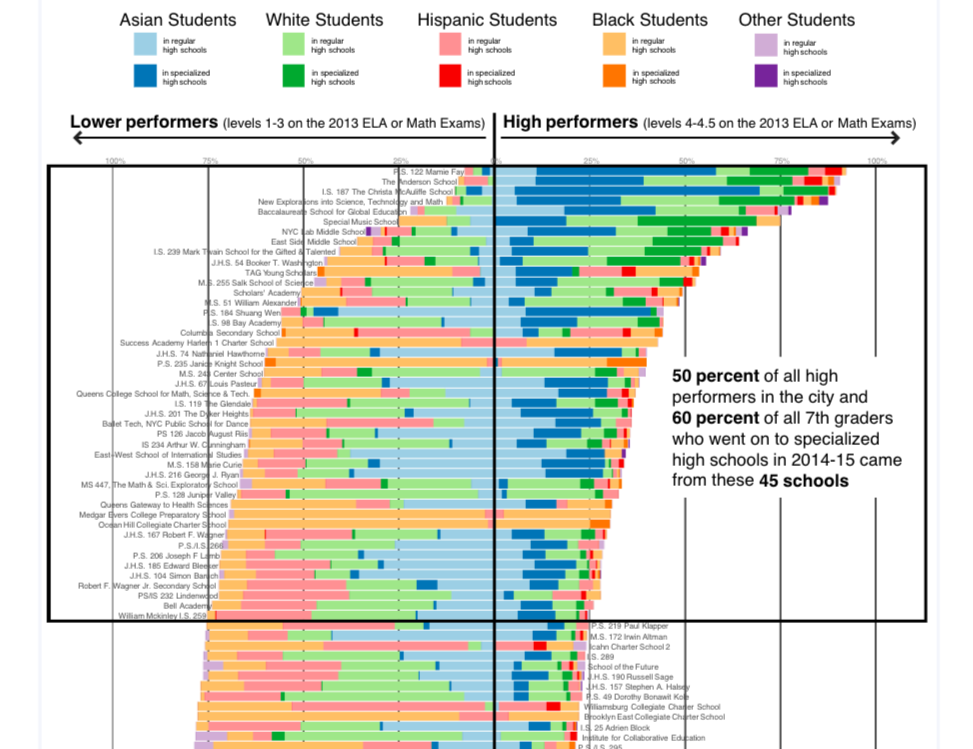
##### Image from patch.com article cited above . . .

### Background
Access to elite high school in New York City is fraught with a dual mission to both provide merit-based opportunity and to reflect the diverse demographics of the city's 1,200,000 students. A seat at one of the Specialized High Schools is soley based upon the SHSAT admissions test and they are largely filled by just a handful of specialty middle schools as based on data released by the city and referenced in the NYTimes and patch.com articles linked above.

According to these articles "... just 45 schools (out of 536 public middle schools) delivered a whopping 60 percent of students to specialized high schools in 2014-15" and "124 middle schools " sent " no students".  "Out of about 600 public middle schools, just 10 account for more than 1,200, or 25 percent of the offers"  The NYtimes article goes on to state that these 10 top performing middle schools are disproportionately Asian and White, in a school system that is two-thirds Hispanic and black. It also cites the following references material . . .

Source: New York City Department of Education |Note: Detailed data for schools with fewer than six offers was not made available. These schools may have anywhere from zero to five offers.  The schools with the highest numbers of offers are mostly in some of New York’s wealthiest neighborhoods, like the Upper West Side in Manhattan and Park Slope in Brooklyn. Twenty-nine students at Junior High School 118 in the Bronx received offers, the highest number for a school in that borough. That’s only 7 percent of the school’s eighth graders, compared with 75 percent of eighth graders at the Christa McAuliffe School in Brooklyn, which sent the most children to the specialized schools last year.

Across the city, only 34 percent of eighth graders even took the entrance exam in 2017, and many schools had only a handful of students take it. At the top 10 schools, 70 percent of students took the test.

Below, see the number of offers for each public middle school in New York City, and the percentage of students at each school who are black and Hispanic.


### Objective
While this background information suggests a more equitable apportionment qualified students to the city's specialized schools is possible, two points of mitigate the articles findings.  The first is that there are many high performing high schools throughout the city that screen students and provide a comparable education to the specialized high schools.  The second point is that specialized and screened schools are dispersed throughout the city--not necessarily in the cities wealthiest or least diverse zipcodes.

The intent of this exercise is to analyze the geographic disbursement of "feeder" Middle Schools based upon their zipcodes and to develop some intuition regarding why specific zipcodes successfully send students to the Specialized High Schools.  The zipcodes with high centrality provide good candidates for investigating what accounts for their success which may range from how where the feeder schools draw their students to the preparation that they provide their students to take the high stakes tests that determines acceptance.

By developing a network graph to analyze successful zipcodes for such feeder schools we can gain insight into where resources might be applied most effectively to provide more equitable access to worthy students that currently are not being reached.

### Load & Merge Datasets

In [27]:
# load libraries
import matplotlib
import pandas as pd
import networkx as nx
from operator import itemgetter

In [28]:
# load 2017-18 middle school locations dataset and clean data
df = pd.read_csv("2017_-_2018_School_Locations.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df = df[['ats_system_code', 'location_name', 'grades_text','location_1']]
df['zip'] = df['location_1'].str.split('\n').str[1]
df['zip'] = df.zip.str.replace(r"[a-zA-Z,','']",'')
df['location_name'] = df['location_name'].str.lower()
df = df[['ats_system_code','location_name','zip']]
df.columns = ['dbn', 'school_name','zip']
df = df[pd.notnull(df['zip'])]
# sort and display by district-borough-number which keys on district, borough and school number
df.sort_values(by=['dbn'], inplace=True)
df.head()

,dbn,school_name,zip
0,01M015,p.s. 015 roberto clemente,10009
1,01M019,p.s. 019 asher levy,10003
2,01M020,p.s. 020 anna silver,10002
3,01M034,p.s. 034 franklin d. roosevelt,10009
4,01M063,the star academy - p.s.63,10009


In [29]:
# load 2017-18 middle school that send students to select specialized high schools based up SHSAT test scores
dfshsat = pd.read_csv("nyc-shsat-data.csv")
dfshsat.columns = dfshsat.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
# filter out schools that send 0 students
dfshsat = dfshsat[dfshsat["offers"] != 's']
dfshsat = dfshsat[dfshsat["offers"] != 's^']
dfshsat = dfshsat[dfshsat["testers"] != 's']
dfshsat['offers'] = dfshsat['offers'].astype(int)
dfshsat['testers'] = dfshsat['testers'].astype(int)
dfshsat['school_name'] = dfshsat['school_name'].str.lower()
dfshsat['accpt_decile'] = (dfshsat['offers'] / dfshsat['testers'] * 10).astype(int) * 10
dfshsat = dfshsat[['dbn', 'school_name','accpt_decile']]
dfshsat.sort_values(by=['accpt_decile'], ascending=False, inplace=True)
# sort and display by acceptance decile or ~percentage of students accepted to specialized high schools
dfshsat.head()

,dbn,school_name,accpt_decile
470,20K187,the christa mcauliffe school\i.s. 187,80
491,03M334,the anderson school,70
480,01M539,"new explorations into science, technology and ...",70
486,02M114,east side middle school,60
498,30Q122,p.s. 122 mamie fay,60


In [30]:
# combine datasets for only schools that send students to specialized schools
df_cd = pd.merge(df, dfshsat, how='inner', on = 'school_name')
df_cd.sort_values(by=['accpt_decile'], ascending=False, inplace=True)
df_cd['zip'] = df_cd['zip'].str.replace(" ","")
df_cd['dbn_x'] = df_cd['dbn_x'].str.replace(" ","")
df_cd.head()

,dbn_x,school_name,zip,dbn_y,accpt_decile
44,20K187,the christa mcauliffe school\i.s. 187,11219,20K187,80
18,03M334,the anderson school,10024,03M334,70
98,30Q300,the 30th avenue school (g&t citywide),11102,30Q300,60
92,30Q122,p.s. 122 mamie fay,11105,30Q122,60
3,02M114,east side middle school,10128,02M114,60


### Draw Initial Graph 
Use the dataframe of combined schools as an edge list for an initial graph display that relates
acceptance rates to zipcodes.  Note, each acceptance decile can have (1 -> many edges) since there are 
multiple schools per zipcode.

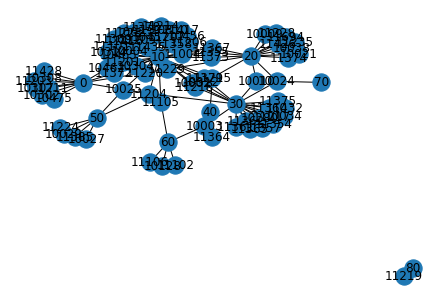

In [33]:
# initial visualization of network
g = nx.from_pandas_edgelist(df_cd,'accpt_decile', 'zip')
nx.draw(g,  with_labels=True)

In [34]:
# Make a list of zips, we'll use it later
zips = list(df_cd.zip.unique())
# Make a list of the decile of students accepted to specialized schools, we'll use it later
acceptances = list(df_cd.accpt_decile.unique())

### Graph differentiation by Node Type

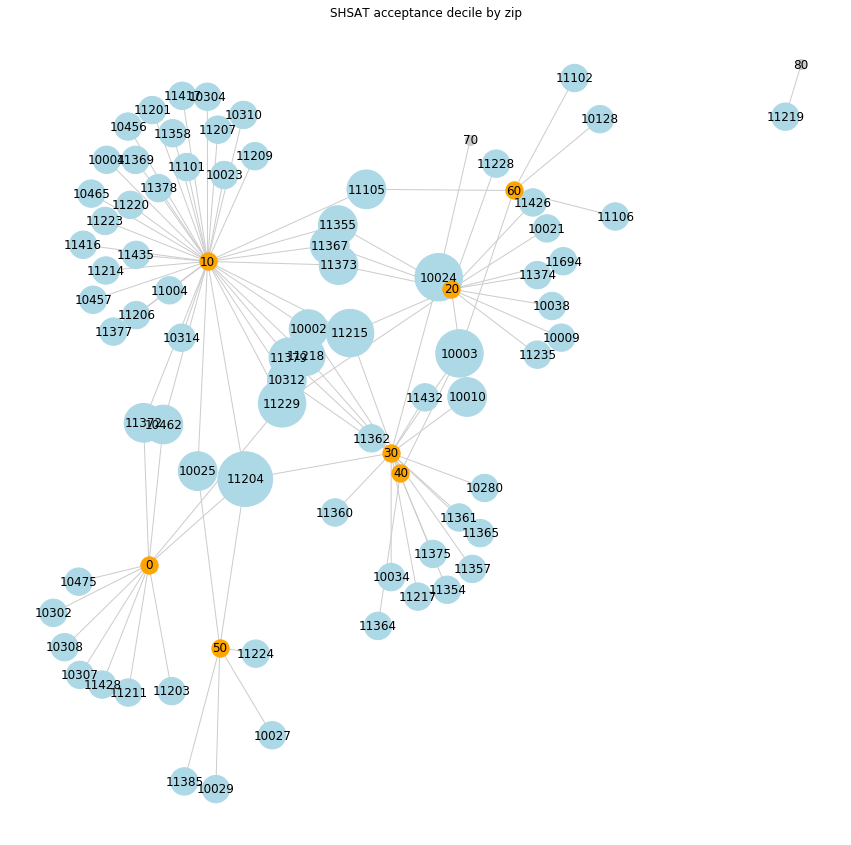

In [35]:
# Generate a more nuanced graph that shows the relationships more clearly
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

# 1. Create the graph
g = nx.from_pandas_edgelist(df_cd, 'accpt_decile','zip')

# 2. Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=25)

# 3. Draw the parts we want
# Edges thin and grey
# Passed small and grey
# zipcodes sized according to their number of connections
# show zipcodes in blue
# Acceptance deciles that are highly connected are a highlighted color

# Go through every zipcode, ask the graph how many
# connections it has. Multiply that by 750 to get the circle size
zip_size = [g.degree(zip) * 750 for zip in zips]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=zips, 
                       node_size=zip_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw every acceptance decile
nx.draw_networkx_nodes(g, layout, nodelist=acceptances, node_color='#cccccc', node_size=100,cmap=plt.cm.Blues)

# Draw acceptances with high Centrality and color those with more than 1 connection to zipcodes
performance_ind = [accpt_decile for accpt_decile in acceptances if g.degree(accpt_decile) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=performance_ind, node_color='orange')
nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

# Label zipcodes in nodes
node_labels1 = dict(zip(zips, zips))
nx.draw_networkx_labels(g, layout, labels=node_labels1)

# Label acceptance deciles in nodes
node_labels2 = dict(zip(acceptances, acceptances))
nx.draw_networkx_labels(g, layout, labels=node_labels2)

# 4. Turn off the axis and label graph
plt.axis('off')
plt.title("SHSAT acceptance decile by zip")

# 5. Tell matplotlib to show it
plt.show()

### Graph degree scaled by Node Size, differentiated by Node Type

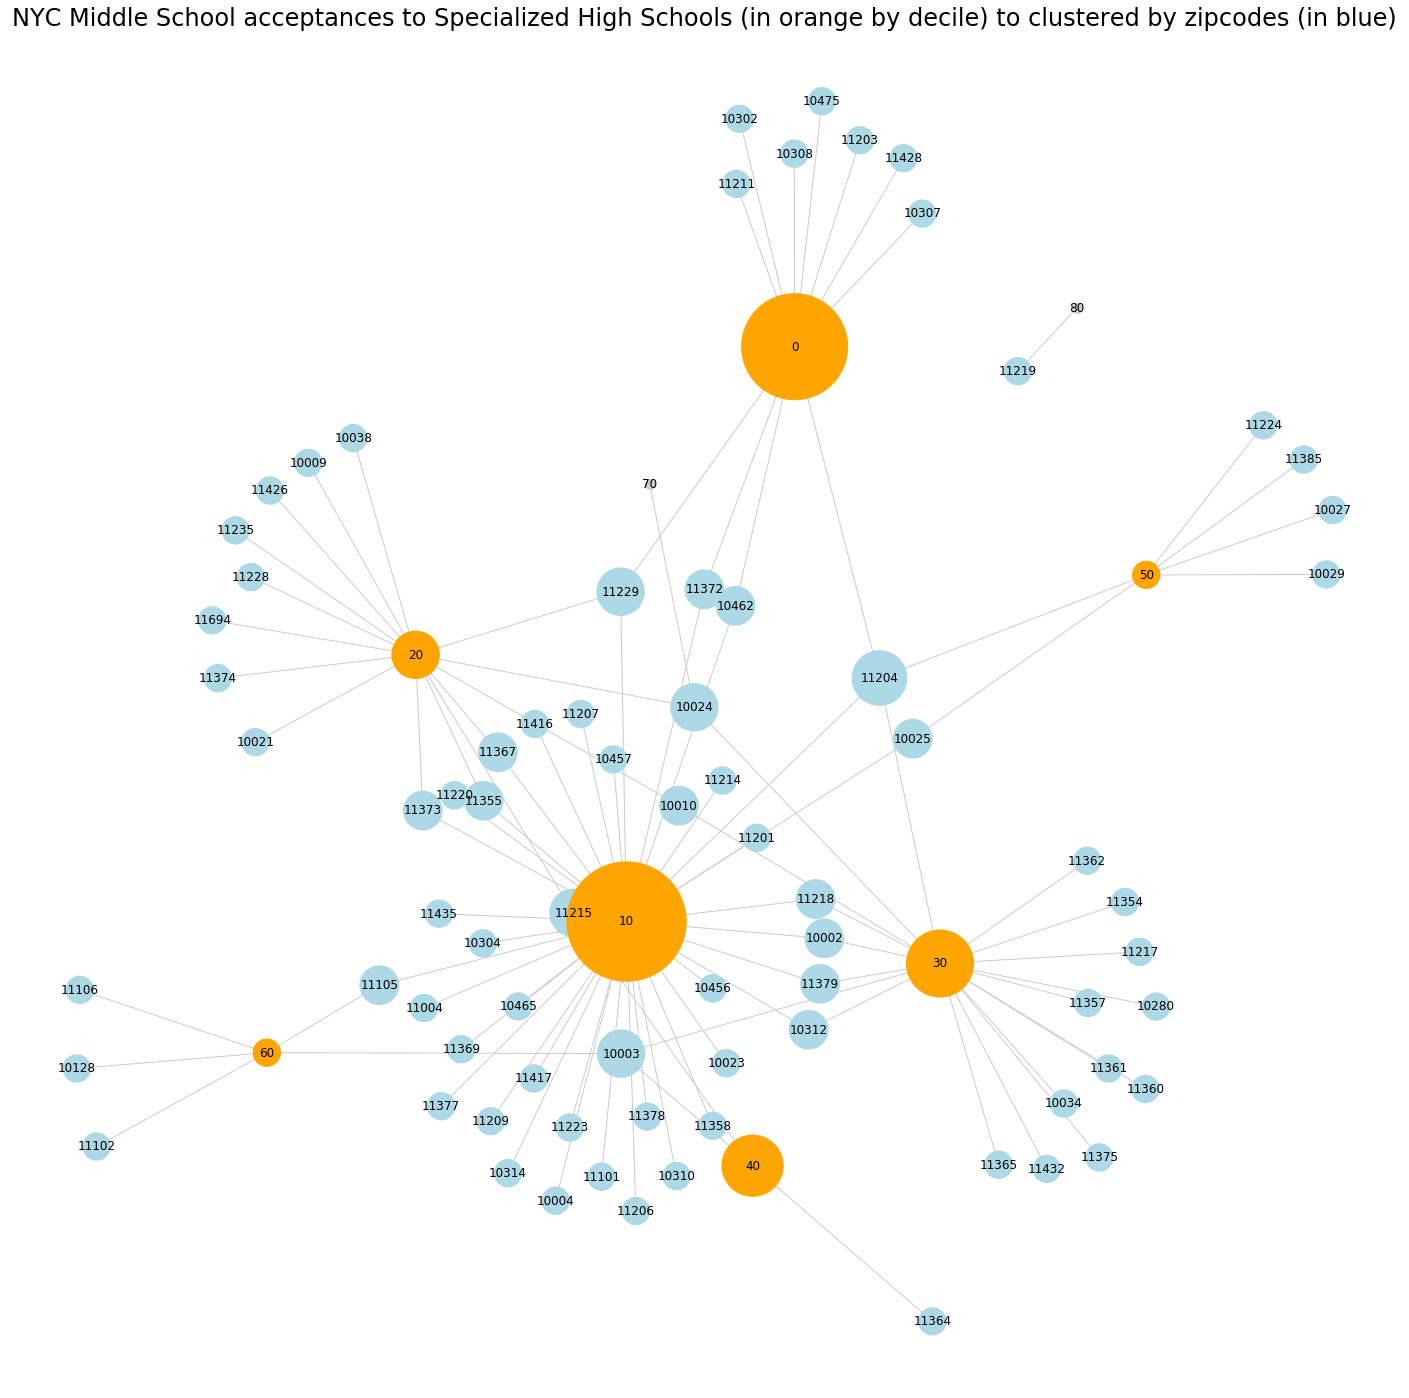

In [36]:
# Articulate centrality by weighting by node size the degree of connectivity.  Also distinguish between 
# acceptance nodes and zipcode nodes using color.
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))

# 1. Create the graph
g = nx.from_pandas_edgelist(df_cd, 'accpt_decile','zip')

# 2. Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=25)

 # 3. Draw the parts we want
# Edges thin and grey
# Passed small and grey
# zipcodes sized according to their number of connections
# show zipcodes in blue
# Acceptance deciles that are highly connected are a highlighted color

# Go through every zipcode, ask the graph how many
# connections it has. Multiply that by 750 to get the circle size
zip_size = [g.degree(zip) * 750 for zip in zips]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=zips, 
                       node_size=zip_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw every acceptance decile
nx.draw_networkx_nodes(g, layout, nodelist=acceptances, node_color='#cccccc', node_size=100,cmap=plt.cm.Blues)

# Draw acceptances with high Centrality and color those with more than 1 connection to zipcodes
acceptances_size = [g.degree(accpt_decile) * 750 for accpt_decile in acceptances]
performance_ind = [accpt_decile for accpt_decile in acceptances if g.degree(accpt_decile) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=performance_ind,node_size=acceptances_size, node_color='orange')
nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

# Label zipcodes in nodes
node_labels1 = dict(zip(zips, zips))
nx.draw_networkx_labels(g, layout, labels=node_labels1)

# Label acceptance deciles in nodes
node_labels2 = dict(zip(acceptances, acceptances))
nx.draw_networkx_labels(g, layout, labels=node_labels2)

# 4. Turn off the axis and label graph
plt.axis('off')
plt.title("NYC Middle School acceptances to Specialized High Schools (in orange by decile) to " +
          "clustered by zipcodes (in blue)",fontsize=24)

# 5. Tell matplotlib to show it
plt.show()

### Analysis by graph inspection . . .
Note that centrality is clear before any statistical anaylysis is done.  Lets evaluate zipcode "11204" as an example as having high degree centrality.  This zipcode has 6 schools that send students to Specialized High Schools at various levels of success.  

Perhaps this warrants further exploration of what is working for each school and why? 

In [37]:
df_cd[df_cd["zip"] == '11204']

,dbn_x,school_name,zip,dbn_y,accpt_decile
51,20K686,brooklyn school of inquiry,11204,20K686,50
43,20K180,the seeall academy,11204,20K180,30
54,21K226,p.s. 226 alfred de b.mason,11204,21K226,10
48,20K227,j.h.s. 227 edward b. shallow,11204,20K227,10
47,20K223,j.h.s. 223 the montauk,11204,20K223,10
52,21K096,i.s. 096 seth low,11204,21K096,0


In [38]:
degree_dict = dict(g.degree(g.nodes()))
nx.set_node_attributes(g, degree_dict, 'degree')
g.node['11204']

{'degree': 4}

### Graph Metrics and Analysis
The dataset will now be explored using basic graph descriptive statistics as well as three widely used node centrality metrics (Degree, Betweenness, and Eigenvector) using the python library NetworkX.

#### Nodes & Edges
There are 2 types of nodes in this dataset; "zipcodes" and "acceptance deciles" to Specialized Schools from these zipcodes.  The deciles are derived from percentage of students in per school accepted.  Edges exist between zipcodes and acceptance deciles, one edge per school in a particular zipcode that has acceptances.

#### Density 
This is simply the ratio of actual edges in the network to all possible edges in the network. In an undirected network like this one, there could be a single edge between any two nodes, but as you saw in the visualization, only a few of those possible edges are actually present. Network density gives you a quick sense of how closely knit your network is.

#### Degree Centrality
Degree is indicative of importance of the node to the network.  The node’s degree is the sum of its edges.  Those with the highest degree are the most "connected" and referred to as hubs.

In [39]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 85
Number of edges: 99
Average degree:   2.3294


In [40]:
density = nx.density(g)
round(density,4)

0.0277

### Centrality

We now want to look at what nodes are important in the network based upon centrality measures.  Although there are varying means of calculating Centrality, this analysis focus's on 3 (degree, betweeness and eigenvector).  This analysis will confirm what is plainly visible in the graph which is that lower acceptance deciles i.e. 10% are the most connected to zipcodes that send students to the Specialized High Schools.  A few zipcodes that have high degree indicate multiple schools that send students in varying degrees to the Specialized High Schools. 

To start with, we get an ordered list of Density Centrality by Zipcode and note that zipcode "11204" does in fact have the highest degree!

In [41]:
degree_dict = dict(g.degree(g.nodes()))
nx.set_node_attributes(g, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
df_density = pd.DataFrame(sorted_degree)
df_density  = df_density.rename(columns={0: 'nodes', 1: 'degree'})
df_density  = df_density[df_density ["nodes"].str.len()  == 5]
df_density[:10]

,nodes,degree
6,11204,4
7,10024,3
8,10003,3
10,11215,3
11,11229,3
12,11105,2
13,10025,2
14,11379,2
15,10002,2
16,11218,2


### Betweeness and Eigenvector Centrality
Betweenness centrality 
Looks at all the shortest paths that pass through a particular node by calculating every possible shortest path in the network.  This measure captures nodes that connect two otherwise seperated clusters because communication between those clusters has to pass through nodes with high betweeness. This sort of node is often referred to as a broker. 

Eigenvector centrality 
Looks at a combination node edges neighboring edges. Eigenvector centrality considers how many hubs you are connected to and is indicative how nodes can get information to many other nodes quickly.

In [42]:
betweenness_dict = nx.betweenness_centrality(g) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(g) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(g, betweenness_dict, 'betweenness')
nx.set_node_attributes(g, eigenvector_dict, 'eigenvector')

### Betweeness Centrality

In this ranked list, Betweeness Centrality is greatest by a twofold factor for the 10% acceptance decile
followed by the  30% then the 20%.  

In [43]:
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
df_b = pd.DataFrame(sorted_betweenness)
df_b = df_b.rename(columns={0: 'nodes', 1: 'betweenness_centrality'})
df_b_accpt_deciles = df_b[df_b["nodes"].str.len()  != 5]
df_b_accpt_deciles.head()

,nodes,betweenness_centrality
0,10,0.628137
1,30,0.306454
2,20,0.209338
4,0,0.163060
5,50,0.092512


The zipcode betweeness centrality ranked list has a smaller range reflecting many more zipcodes and perhaps more a greater disbursement by zipcode of feeder Middle Schools then the reference articles suggested.  There are some outliers such as 11219 with 80% acceptance in Borough Park Brooklyn which all come from "The Christa Mcauliffe school\i.s. 187".  It would be interesting to find out where the students in this school come from and what preparation they get for taking the SHSAT.  
https://insideschools.org/school/20K187

This however appears to be an outlier.

In [45]:
df_b_zips = df_b[df_b["nodes"].str.len()  == 5]
df_b_zips.head()

,nodes,betweenness_centrality
3,11204,0.164178
6,11229,0.072994
8,11105,0.059028
9,11215,0.057678
10,10024,0.046117


### Chi-squared Test for Betweeness Centrality

In this section some basic exploratory data analysis with historgrams show separate out the acceptance decile nodes
from the zipcode nodes and plot their centrality respectively.  The next step is to build a contingency table to illustrate the categorical nature of the nodes and to prepare the data formate for running the Chi Squared test.

Note the objective of the Chi Squared test is to evaluate a hypothesis of independence between each tier of categorical based on expected and observed centrality.  The null hypothesis is that each tier is independent.

Again, Betweeness Centrality emphasizes broker nodes and it is notable that the 30% acceptance tier appears in the Betweeness Centrality histogram but does not in the Eigenvector histogram.  Perhaps 30% acceptance is more of a broker node to underrepresented zipcodes then a hub node?

Text(0.5, 1.0, 'Betweeness Centrality by acceptance decile')

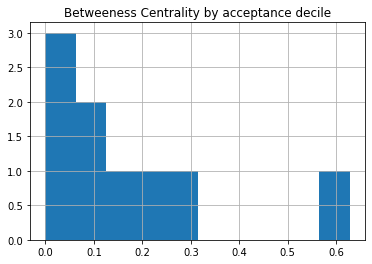

In [115]:
df_b_accpt_deciles['betweenness_centrality'].hist()
plt.title('Betweeness Centrality by acceptance decile')

In [144]:
b_accpt_deciles_contingency_table = pd.crosstab(
    df_b_accpt_deciles['nodes'],
    round(df_b_accpt_deciles['betweenness_centrality'],2),
    margins = True
)
b_accpt_deciles_contingency_table

betweenness_centrality,0.0,0.03,0.07,0.09,0.16,0.21,0.31,0.63,All
nodes,,,,,,,,,
0,0,0,0,0,1,0,0,0,1
10,0,0,0,0,0,0,0,1,1
20,0,0,0,0,0,1,0,0,1
30,0,0,0,0,0,0,1,0,1
40,0,1,0,0,0,0,0,0,1
50,0,0,0,1,0,0,0,0,1
60,0,0,1,0,0,0,0,0,1
70,1,0,0,0,0,0,0,0,1
80,1,0,0,0,0,0,0,0,1


In [148]:
# Chi-square test of independence.
from scipy.stats import chi2_contingency
pd.DataFrame(chi2_contingency(b_accpt_deciles_contingency_table))[:3]
#  Returns:	
## chi2 : float
## The p-value of the test
## dof : int

,0
0,63
1,0.766557
2,72


Since p-value of .77 is greater than the .05 significance level, we don't reject the NULL hypothesis that assumes the acceptances deciles are indepenedent.

Text(0.5, 1.0, 'Betweeness Centrality by zipcode')

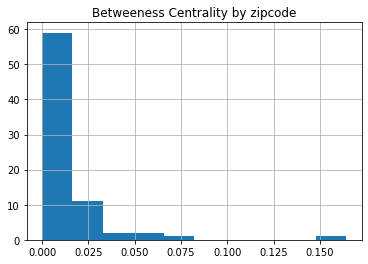

In [150]:
df_b_zips['betweenness_centrality'].hist()
plt.title('Betweeness Centrality by zipcode')

In [152]:
b_zips_contingency_table = pd.crosstab(
    df_b_zips['nodes'],
    round(df_b_zips['betweenness_centrality'],2),
    margins = True
)
b_zips_contingency_table.head()

betweenness_centrality,0.0,0.02,0.03,0.04,0.05,0.06,0.07,0.16,All
nodes,,,,,,,,,
10002,0,0,1,0,0,0,0,0,1
10003,0,0,0,1,0,0,0,0,1
10004,1,0,0,0,0,0,0,0,1
10009,1,0,0,0,0,0,0,0,1
10010,0,1,0,0,0,0,0,0,1


In [153]:
# Chi-square test of independence.
from scipy.stats import chi2_contingency
pd.DataFrame(chi2_contingency(b_zips_contingency_table))[:3]
#  Returns:	
## chi2 : float
## The p-value of the test
## dof : int

,0
0,532
1,0.988033
2,608


Since p-value of .99 is greater than the .05 significance level, we don't reject the NULL hypothesis that assumes the acceptances deciles are indepenedent.

### Eigenvector Centrality

In [119]:
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)
df_e = pd.DataFrame(sorted_eigenvector)
df_e = df_e.rename(columns={0: 'nodes', 1: 'eigenvector_centrality'})
df_e_accpt_deciles = df_e[df_e["nodes"].str.len()  != 5]
df_e_accpt_deciles.head()

,nodes,eigenvector_centrality
0,10,0.660847
1,30,0.170959
3,20,0.144264
41,0,0.099467
44,50,0.045231


In [120]:
df_e_zips = df_e[df_e["nodes"].str.len()  == 5]
df_e_zips.head()

,nodes,eigenvector_centrality
2,11204,0.152133
4,11229,0.140927
5,11379,0.129590
6,10002,0.129590
7,11218,0.129590


### Chi-squared Test for Eigenvector Centrality
In this section some basic exploratory data analysis with historgrams show separate out the acceptance decile nodes from the zipcode nodes and plot their centrality respectively. The next step is to build a contingency table to illustrate the categorical nature of the nodes and to prepare the data formate for running the Chi Squared test.

Note the objective of the Chi Squared test is to evaluate a hypothesis of independence between each tier of categorical based on expected and observed centrality. The null hypothesis is that each tier is independent.

Eigenvector Centrality emphasizes hub nodes and it is notable that the 0% and 10% acceptance tiers appear in the Eigenvector Centrality histogram very prominently, suggesting influential hubs? To reiterate, the 30% hub does not appear in the Eigenvector histogram perhaps indicative of it not being so influential except as a broker as evidenced by its inclusion in the Betweeness Centrality histogram.

In [140]:
e_accpt_deciles_contingency_table = pd.crosstab(
    df_e_accpt_deciles['nodes'],
    round(df_e_accpt_deciles['eigenvector_centrality'],2),
    margins = True
)
e_accpt_deciles_contingency_table

eigenvector_centrality,0.0,0.01,0.02,0.03,0.05,0.1,0.14,0.17,0.66,All
nodes,,,,,,,,,,
0,0,0,0,0,0,1,0,0,0,1
10,0,0,0,0,0,0,0,0,1,1
20,0,0,0,0,0,0,1,0,0,1
30,0,0,0,0,0,0,0,1,0,1
40,0,0,0,1,0,0,0,0,0,1
50,0,0,0,0,1,0,0,0,0,1
60,0,0,1,0,0,0,0,0,0,1
70,0,1,0,0,0,0,0,0,0,1
80,1,0,0,0,0,0,0,0,0,1


In [146]:
# Chi-square test of independence.
from scipy.stats import chi2_contingency
pd.DataFrame(chi2_contingency(e_accpt_deciles_contingency_table))[:3]
#  Returns:	
## chi2 : float
## The p-value of the test
## dof : int

,0
0,72
1,0.752452
2,81


Since p-value of .75 is greater than the .05 significance level, we don't reject the NULL hypothesis that assumes the acceptances deciles are indepenedent.

Text(0.5, 1.0, 'Eigenvector Centrality by zipcode')

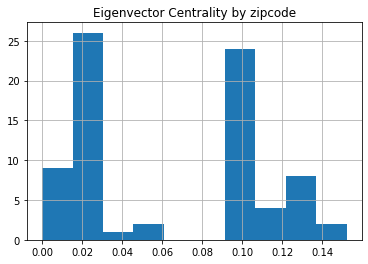

In [122]:
df_e_zips['eigenvector_centrality'].hist()
plt.title('Eigenvector Centrality by zipcode')

In [135]:
e_zips_contingency_table = pd.crosstab(
    df_e_zips['nodes'],
    round(df_e_zips['eigenvector_centrality'],2),
    margins = True
)
e_zips_contingency_table.head()

eigenvector_centrality,0.0,0.01,0.02,0.03,0.05,0.1,0.11,0.12,0.13,0.14,0.15,All
nodes,,,,,,,,,,,,
10002,0,0,0,0,0,0,0,0,1,0,0,1
10003,0,0,0,1,0,0,0,0,0,0,0,1
10004,0,0,0,0,0,1,0,0,0,0,0,1
10009,0,0,1,0,0,0,0,0,0,0,0,1
10010,0,0,0,0,1,0,0,0,0,0,0,1


In [137]:
# Chi-square test of independence.
from scipy.stats import chi2_contingency
pd.DataFrame(chi2_contingency(e_zips_contingency_table))[:3]
#  Returns:	
## chi2 : float
## The p-value of the test
## dof : int

,0
0,760
1,0.971396
2,836


Since p-value of .97 is greater than the .05 significance level, we don't reject the NULL hypothesis that assumes the zipcodes are indepenedent.

,0
0,63
1,0.766557
2,72


eigenvector_centrality,0.0,0.01,0.02,0.03,0.05,0.1,0.14,0.17,0.66,All
nodes,,,,,,,,,,
0,0,0,0,0,0,1,0,0,0,1
10,0,0,0,0,0,0,0,0,1,1
20,0,0,0,0,0,0,1,0,0,1
30,0,0,0,0,0,0,0,1,0,1
40,0,0,0,1,0,0,0,0,0,1
50,0,0,0,0,1,0,0,0,0,1
60,0,0,1,0,0,0,0,0,0,1
70,0,1,0,0,0,0,0,0,0,1
80,1,0,0,0,0,0,0,0,0,1


In [110]:
# Chi-square test of independence.
from scipy.stats import chi2_contingency
pd.DataFrame(chi2_contingency(e_accpt_deciles_contingency_table))[:3]
#  Returns:	
## chi2 : float
## The p-value of the test
## dof : int


,0
0,72
1,0.752452
2,81


### Conclusion of Analysis

The metrics analysis is not suprising after viewing the network graph.  Those hubs with higher levels of centrality appear as larger nodes on the graph.  In addition, those hubs with higher eigenvector centrality are nodes that appear in a more centralized postion on the graph.  Decile 0% and 10% feature prominently.  The categorical variable that I derived to measure success in admissions is the "admissions decile" (to gain admittance to the Specialize High Schools) and the Chi-squared analysis above confirms the assumption that each tier is independent.

There are many more zipcode nodes and they contain fewer edges then the adminissions decile nodes.  There are also a few prominent zipcodes with higher centrality then the rest.  As mentioned in the body of this analysis, such zipcodes warrant further inquiry as to what makes them successful for admissions to the Specialized High Schools and what accounts for the differences in their success between schools.

Overall, my conclusion is that there is a more diverse disbursement of feeder middle schools in zipcodes throughout the city then the reference articles suggest, although the most zipcodes still are not included.  The articles do show that a disproportionate share of seats at Specialized High Schools by race, have most going to Asian students and most the remaining share go to White students.  https://admissionsquad.org/blog/2019/3/21/shsat-results-by-race-2019-vs-2018 Although this study does not analyze racial data per-se, providing more geographically disbursed feeder schools by zipcode may help alleviate those underserved areas and more closely match the observed diversity within the city's student population to its expected diversity which better reflect the city population overall.  